# Imports

In [24]:
import collections

import numpy as np
import torch

import extract
from utils_extraction.classifier import (
    train_ccs_lr,
    make_contrast_pair_data,
    fit_ccs_lr,
)
from utils_extraction.load_utils import (
    load_hidden_states_for_datasets,
    make_permutation_dict,
)
from utils.plotting import plot_accuracy, plot_history
from utils_extraction.projection import IdentityReduction
from utils_generation import hf_utils
from utils_generation.hf_auth_token import HF_AUTH_TOKEN

# Config

In [2]:
_config = dict(
    model="meta-llama/Llama-2-7b-chat-hf",
    datasets=["dbpedia-14"],
    labeled_datasets=["imdb"],
    eval_datasets=["dbpedia-14", "imdb"],
    prefix="normal-bananashed",
    test_prefix="normal-bananashed",
    method_list=["pseudolabel"],
    mode="auto",
    load_dir="generation_results",
    location="auto",
    layer=-1,
)
_config["num_layers"] = hf_utils.get_num_hidden_layers(
    _config["model"], use_auth_token=HF_AUTH_TOKEN
)


_config = extract._format_config(_config)
train_datasets = _config["datasets"]
labeled_train_datasets = _config["labeled_datasets"]
eval_datasets = _config["eval_datasets"]
prefix = _config["prefix"]
test_prefix = _config["test_prefix"] if _config["test_prefix"] is not None else prefix
model = _config["model"]

/nas/ucb/ebronstein/anaconda3/envs/exhaustive-ccs/lib/python3.9/site-packages/transformers/models/auto/configuration_auto.py:1085: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


# Data

In [3]:
datasets_to_load = list(set(train_datasets + labeled_train_datasets + eval_datasets))
data_dict = None
eval_results = collections.defaultdict(list)

# Generate data.
prefixes = set([prefix, test_prefix])
mode_to_data = {}
for method in _config["method_list"]:
    if method == "0-shot":
        continue

    mode = (
        _config["mode"]
        if _config["mode"] != "auto"
        else "concat"  # TODO: add "pseudolabel" to default_method_mode
    )
    if mode in mode_to_data:
        continue

    mode_to_data[mode] = {}
    for prefix_ in prefixes:
        # Only generate the data (and other related dictionaries) once to keep
        # them the same across methods.
        data_dict = load_hidden_states_for_datasets(
            _config["load_dir"],
            mdl_name=model,
            dataset_list=datasets_to_load,
            prefix=prefix_,
            location=_config["location"],
            layer=_config["layer"],
            mode=mode,
        )
        mode_to_data[mode][prefix_] = data_dict

mode = "concat"
data_dict = mode_to_data[mode]
permutation_dict = {
    ds: make_permutation_dict(data_dict[prefix][ds]) for ds in datasets_to_load
}
projection_datasets = set(train_datasets + labeled_train_datasets)
# Arbitrarily use prefix instead of test_prefix to index into data_dict
# since the number of prompts should be the same for both.
projection_dict = {
    ds: list(range(len(data_dict[prefix][ds]))) for ds in projection_datasets
}

unlabeled_train_data_dict = {
    ds: range(len(data_dict[prefix][ds])) for ds in train_datasets
}
labeled_train_data_dict = {
    ds: range(len(data_dict[prefix][ds])) for ds in labeled_train_datasets
}

test_dict = {ds: range(len(data_dict[test_prefix][ds])) for ds in eval_datasets}

# Pseudo-label

In [25]:
labeled_prefix = prefix
unlabeled_prefix = test_prefix
project_along_mean_diff = False
projection_model = IdentityReduction()
train_kwargs = dict(
    n_tries=1, n_epochs=10000, lr=1e-2, unsup_weight=0.0, sup_weight=1.0
)
device = "cuda" if torch.cuda.is_available() else "cpu"
logger = None

# Labeled data.
(train_sup_x0, train_sup_x1), train_sup_y = make_contrast_pair_data(
    target_dict=labeled_train_data_dict,
    data_dict=data_dict[labeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="train",
    project_along_mean_diff=project_along_mean_diff,
)
(test_sup_x0, test_sup_x1), test_sup_y = make_contrast_pair_data(
    target_dict=labeled_train_data_dict,
    data_dict=data_dict[labeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="test",
    project_along_mean_diff=project_along_mean_diff,
)
# Unlabeled data.
(train_unsup_x0, train_unsup_x1), train_unsup_y = make_contrast_pair_data(
    target_dict=unlabeled_train_data_dict,
    data_dict=data_dict[unlabeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="train",
    project_along_mean_diff=project_along_mean_diff,
)
(test_unsup_x0, test_unsup_x1), test_unsup_y = make_contrast_pair_data(
    target_dict=unlabeled_train_data_dict,
    data_dict=data_dict[unlabeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="test",
    project_along_mean_diff=project_along_mean_diff,
)

fit_result = fit_ccs_lr(
    train_sup_x0,
    train_sup_x1,
    train_sup_y,
    train_unsup_x0,
    train_unsup_x1,
    train_unsup_y,
    test_sup_x0,
    test_sup_x1,
    test_sup_y,
    test_unsup_x0,
    test_unsup_x1,
    test_unsup_y,
    verbose=True,
    device=device,
    logger=logger,
    **train_kwargs,
)
lr_probe = fit_result["best_probe"]

Epoch 100/10000, Loss: 1.5857146978378296
Epoch 200/10000, Loss: 1.1173113584518433
Epoch 300/10000, Loss: 0.8551942706108093
Epoch 400/10000, Loss: 0.6788846254348755
Epoch 500/10000, Loss: 0.5609154105186462
Epoch 600/10000, Loss: 0.48183587193489075
Epoch 700/10000, Loss: 0.4278987646102905
Epoch 800/10000, Loss: 0.38992059230804443
Epoch 900/10000, Loss: 0.3619067072868347
Epoch 1000/10000, Loss: 0.3401956260204315
Epoch 1100/10000, Loss: 0.3226529359817505
Epoch 1200/10000, Loss: 0.30803021788597107
Epoch 1300/10000, Loss: 0.2955726981163025
Epoch 1400/10000, Loss: 0.2848128378391266
Epoch 1500/10000, Loss: 0.2754732668399811
Epoch 1600/10000, Loss: 0.2674338221549988
Epoch 1700/10000, Loss: 0.26073357462882996
Epoch 1800/10000, Loss: 0.2555309534072876
Epoch 1900/10000, Loss: 0.2518558204174042
Epoch 2000/10000, Loss: 0.24926717579364777
Epoch 2100/10000, Loss: 0.24713100492954254
Epoch 2200/10000, Loss: 0.245153546333313
Epoch 2300/10000, Loss: 0.243279367685318
Epoch 2400/10000

In [84]:
(
    np.mean(fit_result["eval_histories"][-1]["train_sup_acc"]),
    np.mean(fit_result["eval_histories"][-1]["test_sup_acc"]),
    np.mean(fit_result["eval_histories"][-1]["train_unsup_acc"]),
    np.mean(fit_result["eval_histories"][-1]["test_unsup_acc"]),
)

(0.952810241552646, 0.9464877943792743, 0.7890914196739653, 0.7920296735868244)

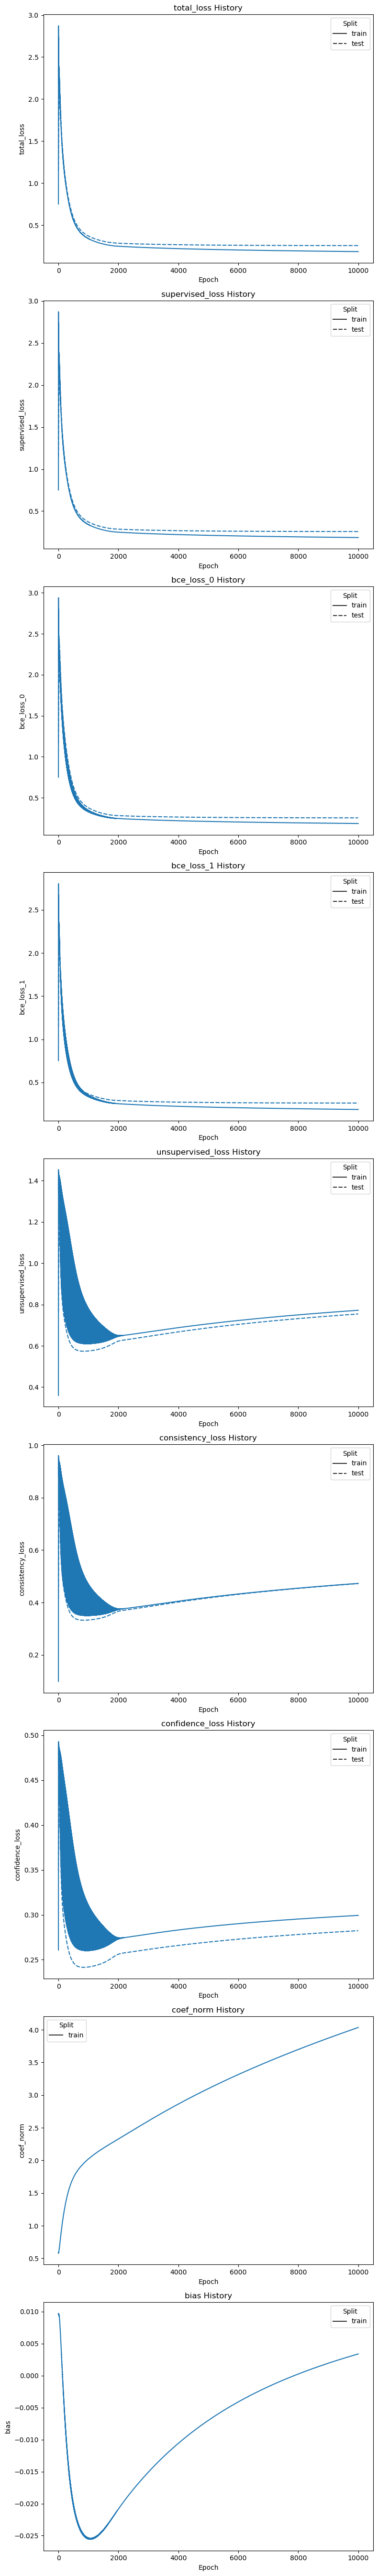

In [28]:
plot_history(fit_result)

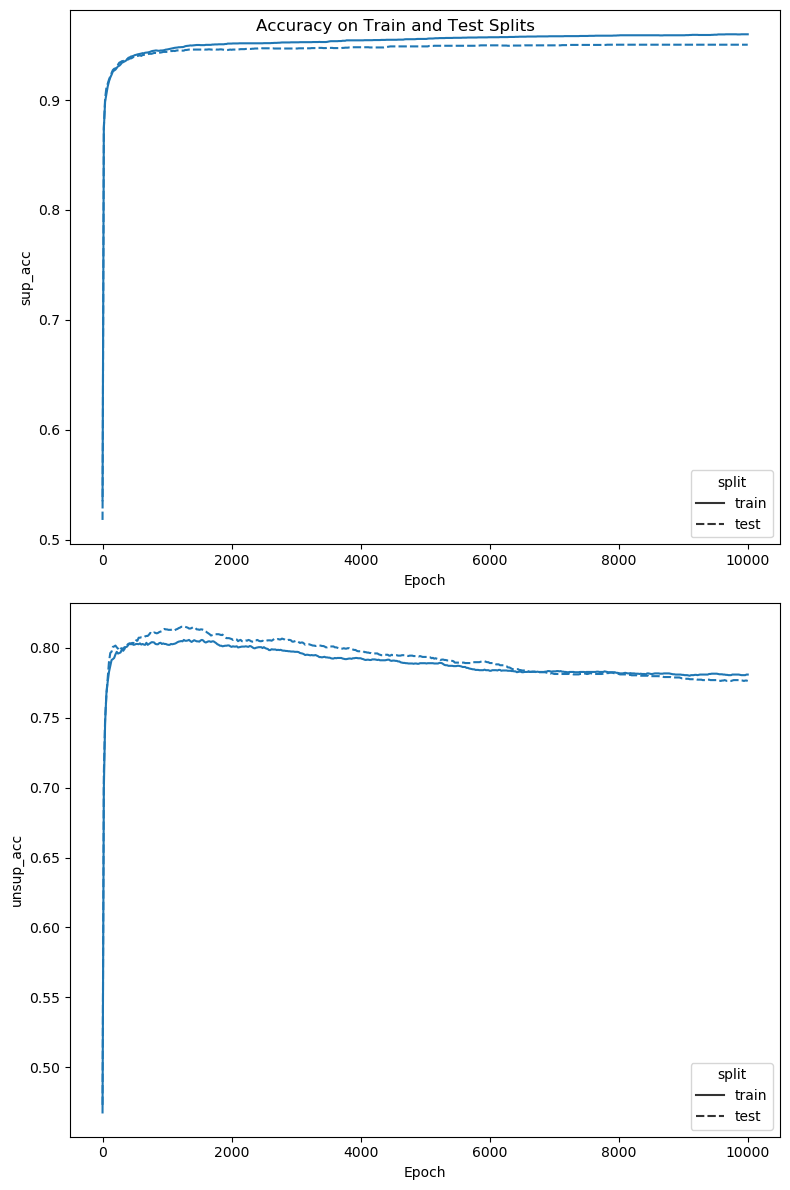

,trial,split,type,epoch,accuracy
0,0,train,sup_acc,0,0.535769
1,0,train,sup_acc,20,0.873718
2,0,train,sup_acc,40,0.898590
3,0,train,sup_acc,60,0.905641
4,0,train,sup_acc,80,0.912308
...,...,...,...,...,...
1999,0,test,unsup_acc,9920,0.776563
2000,0,test,unsup_acc,9940,0.776250
2001,0,test,unsup_acc,9960,0.776563
2002,0,test,unsup_acc,9980,0.776563


In [29]:
plot_accuracy(fit_result)

In [64]:
# Convert data to tensors.
train_sup_x0 = torch.tensor(train_sup_x0, dtype=torch.float, device=device)
train_sup_x1 = torch.tensor(train_sup_x1, dtype=torch.float, device=device)
train_sup_y = torch.tensor(train_sup_y, dtype=torch.float, device=device).view(-1, 1)
train_unsup_x0 = torch.tensor(train_unsup_x0, dtype=torch.float, device=device)
train_unsup_x1 = torch.tensor(train_unsup_x1, dtype=torch.float, device=device)
train_unsup_y = torch.tensor(train_unsup_y, dtype=torch.float, device=device).view(
    -1, 1
)
test_sup_x0 = torch.tensor(test_sup_x0, dtype=torch.float, device=device)
test_sup_x1 = torch.tensor(test_sup_x1, dtype=torch.float, device=device)
test_sup_y = torch.tensor(test_sup_y, dtype=torch.float, device=device).view(-1, 1)
test_unsup_x0 = torch.tensor(test_unsup_x0, dtype=torch.float, device=device)
test_unsup_x1 = torch.tensor(test_unsup_x1, dtype=torch.float, device=device)
test_unsup_y = torch.tensor(test_unsup_y, dtype=torch.float, device=device).view(-1, 1)

train_unsup_x0_probs = lr_probe.predict(train_unsup_x0)
train_unsup_x1_probs = lr_probe.predict(train_unsup_x1)

/tmp/ipykernel_4000513/3651702557.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sup_x0 = torch.tensor(train_sup_x0, dtype=torch.float, device=device)
/tmp/ipykernel_4000513/3651702557.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sup_x1 = torch.tensor(train_sup_x1, dtype=torch.float, device=device)
/tmp/ipykernel_4000513/3651702557.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sup_y = torch.tensor(train_sup_y, dtype=torch.float, device=device).view(-1, 1)
/tmp/ipykernel_4000513/3651702557.py:6: UserWarn

In [65]:
prob_threshold = 0.8
x0_prob_high_mask = train_unsup_x0_probs >= prob_threshold
x1_prob_high_mask = train_unsup_x1_probs >= prob_threshold
confidence_mask = (x0_prob_high_mask | x1_prob_high_mask).cpu().numpy()
consistency_mask = torch.logical_xor(x0_prob_high_mask, x1_prob_high_mask).cpu().numpy()

In [66]:
confidence_mask.sum(), consistency_mask.sum()

(2046, 915)

In [89]:
train_unsup_acc, train_unsup_p0, train_unsup_p1, train_unsup_probs = (
    lr_probe.evaluate_accuracy(train_unsup_x0, train_unsup_x1, train_unsup_y)
)

In [93]:
train_unsup_p0 = train_unsup_p0.cpu().numpy()
train_unsup_p1 = train_unsup_p1.cpu().numpy()
train_unsup_probs = train_unsup_probs.cpu().numpy()

In [101]:
consistent_train_unsup_p0 = train_unsup_p0[consistency_mask]
consistent_train_unsup_p1 = train_unsup_p1[consistency_mask]
consistent_train_unsup_pseudo_labels = np.argmax(
    np.stack([consistent_train_unsup_p0, consistent_train_unsup_p1], axis=1), axis=1
)[:, None]

In [103]:
n_consistent_pairs = consistency_mask.sum()
broadcast_consistency_mask = np.broadcast_to(consistency_mask, train_unsup_x0.shape)
consistent_train_unsup_x0 = (
    train_unsup_x0.cpu()
    .numpy()[broadcast_consistency_mask]
    .reshape((n_consistent_pairs, -1))
)
consistent_train_unsup_x1 = (
    train_unsup_x1.cpu()
    .numpy()[broadcast_consistency_mask]
    .reshape((n_consistent_pairs, -1))
)

In [106]:
# Concatenate original labeled data with the pseudo-labeled data.
new_train_sup_x0 = np.concatenate(
    [train_sup_x0.cpu().numpy(), consistent_train_unsup_x0], axis=0
)
new_train_sup_x1 = np.concatenate(
    [train_sup_x1.cpu().numpy(), consistent_train_unsup_x1], axis=0
)
new_train_sup_y = np.concatenate(
    [train_sup_y.cpu().numpy(), consistent_train_unsup_pseudo_labels], axis=0
)

In [107]:
fit_result_with_pseudolabels = fit_ccs_lr(
    new_train_sup_x0,
    new_train_sup_x1,
    new_train_sup_y,
    train_unsup_x0,
    train_unsup_x1,
    train_unsup_y,
    test_sup_x0,
    test_sup_x1,
    test_sup_y,
    test_unsup_x0,
    test_unsup_x1,
    test_unsup_y,
    verbose=True,
    device=device,
    logger=logger,
    **train_kwargs,
)
lr_probe_with_pseudolabels = fit_result_with_pseudolabels["best_probe"]

/nas/ucb/ebronstein/Exhaustive-CCS/utils_extraction/classifier.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_unsup_x0 = torch.tensor(train_unsup_x0, dtype=torch.float, device=device)
/nas/ucb/ebronstein/Exhaustive-CCS/utils_extraction/classifier.py:527: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_unsup_x1 = torch.tensor(train_unsup_x1, dtype=torch.float, device=device)
/nas/ucb/ebronstein/Exhaustive-CCS/utils_extraction/classifier.py:528: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_unsup_y = torch.tensor(trai

Epoch 100/10000, Loss: 1.5708794593811035
Epoch 200/10000, Loss: 1.163187026977539
Epoch 300/10000, Loss: 0.9120062589645386
Epoch 400/10000, Loss: 0.7379545569419861
Epoch 500/10000, Loss: 0.6157325506210327
Epoch 600/10000, Loss: 0.5301748514175415
Epoch 700/10000, Loss: 0.4697965383529663
Epoch 800/10000, Loss: 0.42621201276779175
Epoch 900/10000, Loss: 0.3936784863471985
Epoch 1000/10000, Loss: 0.36845165491104126
Epoch 1100/10000, Loss: 0.3481728434562683
Epoch 1200/10000, Loss: 0.3313709497451782
Epoch 1300/10000, Loss: 0.3171161413192749
Epoch 1400/10000, Loss: 0.30480629205703735
Epoch 1500/10000, Loss: 0.29404670000076294
Epoch 1600/10000, Loss: 0.28458860516548157
Epoch 1700/10000, Loss: 0.2763091027736664
Epoch 1800/10000, Loss: 0.26922157406806946
Epoch 1900/10000, Loss: 0.26348069310188293
Epoch 2000/10000, Loss: 0.25924843549728394
Epoch 2100/10000, Loss: 0.2563241422176361
Epoch 2200/10000, Loss: 0.25408634543418884
Epoch 2300/10000, Loss: 0.25207895040512085
Epoch 2400/

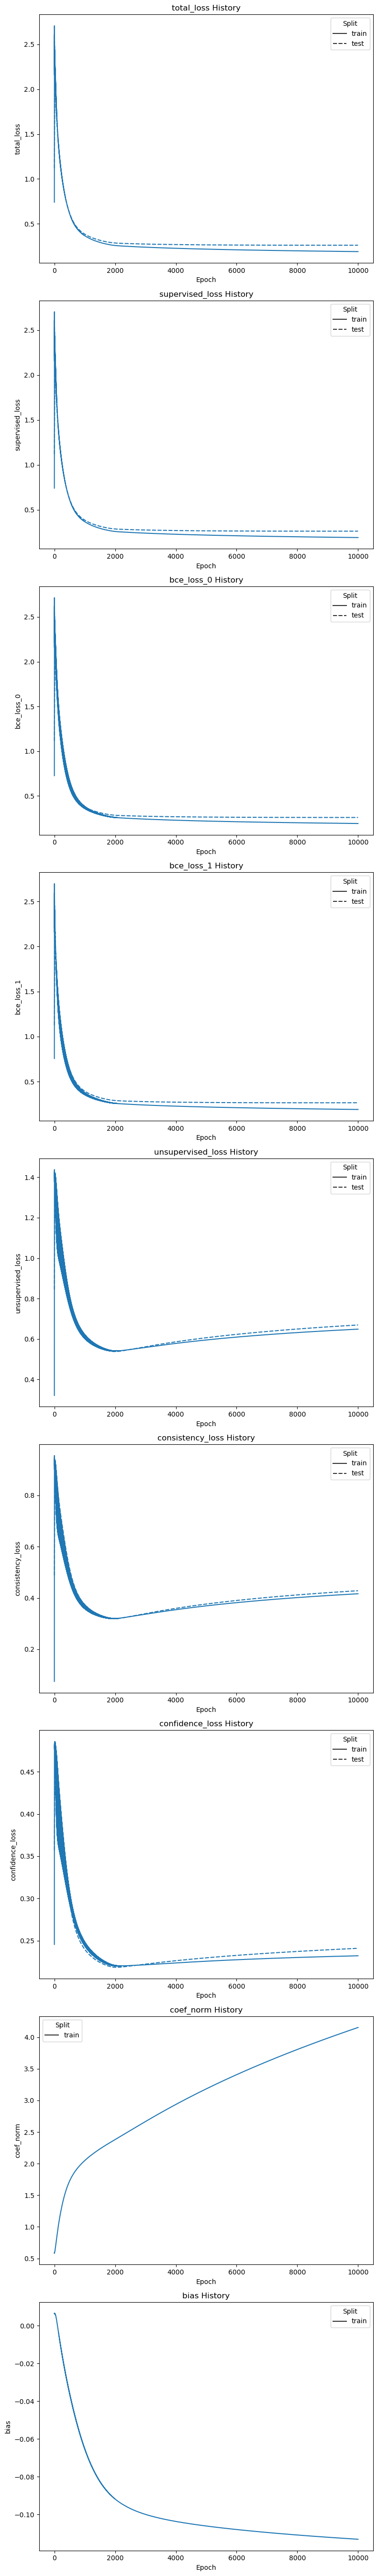

In [108]:
plot_history(fit_result_with_pseudolabels)

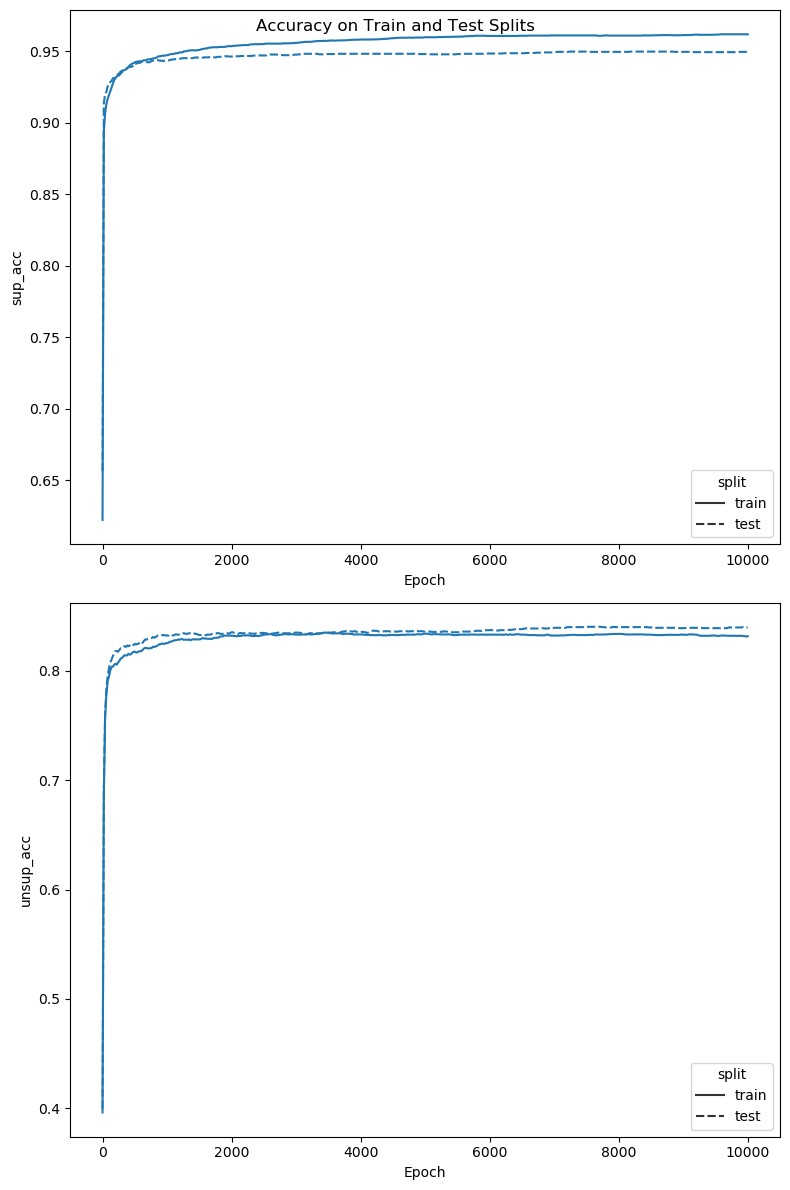

,trial,split,type,epoch,accuracy
0,0,train,sup_acc,0,0.622375
1,0,train,sup_acc,20,0.893746
2,0,train,sup_acc,40,0.906713
3,0,train,sup_acc,60,0.913253
4,0,train,sup_acc,80,0.916810
...,...,...,...,...,...
1999,0,test,unsup_acc,9920,0.840000
2000,0,test,unsup_acc,9940,0.840000
2001,0,test,unsup_acc,9960,0.840000
2002,0,test,unsup_acc,9980,0.839687


In [109]:
plot_accuracy(fit_result_with_pseudolabels)

In [110]:
(
    lr_probe.evaluate_accuracy(train_sup_x0, train_sup_x1, train_sup_y)[0],
    lr_probe.evaluate_accuracy(test_sup_x0, test_sup_x1, test_sup_y)[0],
    lr_probe.evaluate_accuracy(train_unsup_x0, train_unsup_x1, train_unsup_y)[0],
    lr_probe.evaluate_accuracy(test_unsup_x0, test_unsup_x1, test_unsup_y)[0],
)

(0.959871768951416, 0.9503846168518066, 0.78083336353302, 0.7762500047683716)

In [111]:
(
    lr_probe_with_pseudolabels.evaluate_accuracy(
        train_sup_x0, train_sup_x1, train_sup_y
    )[0],
    lr_probe_with_pseudolabels.evaluate_accuracy(test_sup_x0, test_sup_x1, test_sup_y)[
        0
    ],
    lr_probe_with_pseudolabels.evaluate_accuracy(
        train_unsup_x0, train_unsup_x1, train_unsup_y
    )[0],
    lr_probe_with_pseudolabels.evaluate_accuracy(
        test_unsup_x0, test_unsup_x1, test_unsup_y
    )[0],
)

(0.9583333134651184,
 0.9496153593063354,
 0.8316667079925537,
 0.8396874666213989)